# How to start your PySpark journey


<div style="text-align: right">
<b>Patryk Pilarski</b><br>
1patryk.pilarski@gmail.com<br>
p.pilarski@sages.com.pl
</div>

## What is Apache Spark?

**Apache Spark** is a multi-language engine for executing data engineering, data science, and machine learning on single-node machines or clusters.

Supported languages:
- Python (PySpark)
- Scala
- Java
- R
- SQL

Unified open-source engine for distributed computing

**Components:**

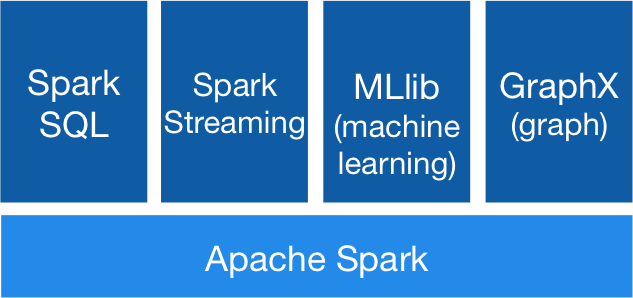

* Spark "core" - "low level" (old) interface with main data abstraction called RDD
* Spark SQL - main, easy to use interface for working with (mostly) structured data
* Spark MLlib - module offering ML models and other related tools
* Spark Streaming - component enabling processing data streams
* Spark GraphX - graph processing in Spark

**Architecture:**

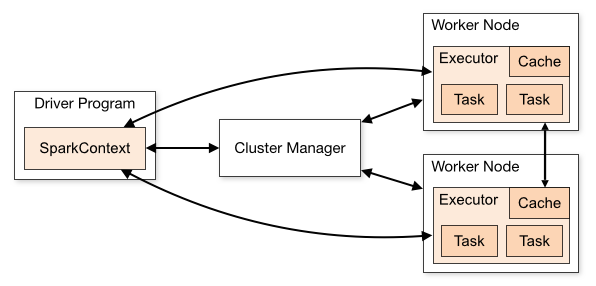

* driver - JVM process running main program with SparkContext
* executor(s) - JVM process running on worker node(s) that executes tasks and is processing data. Every Spark application has it's own executor(s)
* cluster manager - manages resources on cluster, Spark can work with: YARN, Mesos, Kubernetes, Standalone

**SparkContext:**
* entrypoint for working with Spark
* coordinates processes on cluster
* stopping SparkContext == stopping Spark application
* usually called `sc`
* steps to create SparkContext in PySpark:

> import pyspark  
> sc = pyspark.SparkContext(appName="my_app")

**SparkSession:**
* introduced in Spark 2.0
* consists of SparkContext, SQLContext and HiveContext
* usually called `spark`
* steps to create SparkSession in PySpark:

> from pyspark.sql import SparkSession  
> spark = SparkSession.builder.getOrCreate()


**RDD:**
* main data abstraction in Spark
* R - resilient
* D - distributed
* D - dataset
* immutable
* in-memory
* lazy evaluated
* parallel
* two types of operations: actions and transformations

**DataFrame:**
* tabular data abstraction from Spark SQL
* contains additional info about data structure (schema)
* allows for woking with data using SQL queries
* optimized by Catalyst optimizer

## How do I get it?

### Install locally
You will need: Java 8, Python 3.7+. Having those, it's enought to run `pip install pyspark`

**or**

### Find yourself a cluster
Spark is present on most of modern clusters

## How do I use it?

[API Reference](https://spark.apache.org/docs/latest/api/python/reference/index.html)

### Imports and SparkSession initialization

*to execute cell press: shift + enter or hit Run on the toolbar*

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f

spark = SparkSession.builder.appName("demo").getOrCreate()

### Reading data
[Source](https://archive.ics.uci.edu/ml/datasets/adult)

In [ ]:
df = spark.read.parquet("data")

### Basic info about data

In [ ]:
df.printSchema()

In [ ]:
df.show()

In [ ]:
df.columns

In [ ]:
df.count()

In [ ]:
df.describe("age", "capital_gain", "hours_per_week").show()

### SQL queries

In [ ]:
df.createOrReplaceTempView("df")

In [ ]:
spark.sql("SELECT age, education FROM df").show()

### Data exploration

#### What levels of education appear in the data and how often?

In [ ]:
df.select("education").distinct().show()

In [ ]:
spark.sql("SELECT DISTINCT education FROM df").show()

---

In [ ]:
df.groupBy("education").count().show()

In [ ]:
spark.sql("SELECT education, count(*) AS count FROM df GROUP BY education").show()

---

In [ ]:
df.groupBy("education").count().orderBy("count").show()

In [ ]:
spark.sql("SELECT education, count(*) AS count FROM df GROUP BY education ORDER BY count").show()

> **TODO**: How many people earn more than 50k and how many earn less? (`earnings`)

#### What is the lowest, highest and average age of people that were `Never-married`?

In [ ]:
df.groupBy("marital_status").agg(f.max("age"), f.min("age"), f.avg("age")).show()

In [ ]:
spark.sql("SELECT marital_status, max(age), min(age), avg(age) FROM df GROUP BY marital_status").show()

---

In [ ]:
df.where(df["marital_status"] == "Never-married").select(f.max("age"), f.min("age"), f.avg("age")).show()

In [ ]:
spark.sql("SELECT max(age), min(age), avg(age) FROM df WHERE marital_status = 'Never-married'").show()

> **TODO**: Among people earning over 50k, how often do individual countries of origin appear? (`earnings`, `native_country`)

#### What percentage of people with higher education earn over 50k? What is the situation for the rest of the people?
(Masters, Bachelors, Doctorate)

In [ ]:
df.select("earnings", 
          f.when(df.education.isin("Masters", "Bachelors", "Doctorate"), "high")
          .otherwise("rest").alias("flag")).show()

In [ ]:
q = """
SELECT earnings,
CASE WHEN (education IN ('Masters', 'Bachelors', 'Doctorate')) THEN 'high'
ELSE 'rest' END AS flag FROM df
"""
spark.sql(q).show()

---

In [ ]:
df.select("earnings", 
          f.when(df.education.isin("Masters", "Bachelors", "Doctorate"), "high")
          .otherwise("rest").alias("flag"))\
.groupBy("flag", "earnings").count().show()

In [ ]:
q = """
SELECT earnings,
CASE WHEN (education IN ('Masters', 'Bachelors', 'Doctorate')) THEN 'high'
ELSE 'rest' END AS flag,
count(*) AS count FROM df
GROUP BY 1, 2
"""
spark.sql(q).show()

---

In [ ]:
df.select(f.when(df.earnings == ">50K", 1).otherwise(0).alias("earnings"), 
          f.when(df.education.isin("Masters", "Bachelors", "Doctorate"), "high")
          .otherwise("rest").alias("flag"))\
.groupBy("flag").agg((f.sum("earnings") / f.count("earnings")).alias("percent")).show()

In [ ]:
q = """
SELECT flag, sum(earnings) / count(earnings) AS percent FROM
(
   SELECT CASE WHEN earnings = '>50K' THEN 1 ELSE 0 END AS earnings,
   CASE WHEN (education IN ('Masters', 'Bachelors', 'Doctorate')) THEN 'high'
   ELSE 'rest' END AS flag FROM df
)
GROUP BY flag
"""
spark.sql(q).show()

In [ ]:
q = """
WITH mapping AS (
   SELECT CASE WHEN earnings = '>50K' THEN 1 ELSE 0 END AS earnings,
   CASE WHEN (education IN ('Masters', 'Bachelors', 'Doctorate')) THEN 'high'
   ELSE 'rest' END AS flag FROM df
)

SELECT flag, sum(earnings) / count(earnings) AS percent FROM mapping
GROUP BY flag
"""
spark.sql(q).show()

> **TODO**: Compare the average number of hours worked per week in two groups: manual workers, rest of the people  
(Handlers-cleaners, Farming-fishing, Craft-repair, Transport-moving)

### Writing data

In [ ]:
df.select("age", "education").write.parquet("output")

In [ ]:
spark.read.parquet("output").show()

### Bonus: ML

In [ ]:
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.ml import evaluation

In [ ]:
rf = feature.RFormula(formula="earnings ~ .")
rfTransformer = rf.fit(df)

In [ ]:
df_ml = rfTransformer.transform(df).select("label", "features")
df.show(5)
df_ml.show(5)

In [ ]:
forest = classification.RandomForestClassifier()
forestModel = forest.fit(df_ml)

In [ ]:
df_preds = forestModel.transform(df_ml)
df_preds.show()

In [ ]:
evaluator = evaluation.BinaryClassificationEvaluator()
evaluator.evaluate(df_preds)

---